# Data Analysis

## Dependencies

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Import Data

In [2]:
account_data = pd.read_csv("../../assets/clean/account.csv")
card_data = pd.read_csv("../../assets/clean/card_dev.csv")
client_data = pd.read_csv("../../assets/clean/client.csv")
disp_data = pd.read_csv("../../assets/clean/disp.csv", dtype={"disp_id": int, "client_id": int, "account_id": int, "type": str})
district_data = pd.read_csv("../../assets/clean/district.csv")
loan_data = pd.read_csv("../../assets/clean/loan_dev.csv")
transaction_data = pd.read_csv("../../assets/clean/trans_dev.csv", dtype=
    {"trans_id": int, "account_id": int, "date": str, "type": str, "operation": str, "amount": float, "balance": float, "k_symbol": str, "bank": str, "account": str}
)


## Data Exploratory Analysis

In [3]:
# Variable used to avoid re-running certain cells
DATA_IS_LOADED = False

### Change Pandas display settings

In [4]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

### Analyze the Size of each Dataset

In [5]:
print("=============================================\n")
print("Number of rows for each dataset: \n")
print(f"Account: {len(account_data)}")
print(f"Card: {len(card_data)}")
print(f"Client: {len(client_data)}")
print(f"Disposition: {len(disp_data)}")
print(f"District: {len(district_data)}")
print(f"Loan: {len(loan_data)}")
print(f"Transaction: {len(transaction_data)}")


Number of rows for each dataset: 

Account: 4500
Card: 177
Client: 5369
Disposition: 5369
District: 77
Loan: 328
Transaction: 396685


### Get Missing Values

In [6]:
print("=============================================\n")
print("Missing values for each dataset: \n")
print(f"Account: \n{account_data.isnull().sum()} \n")
print(f"Card: \n{card_data.isnull().sum()} \n")
print(f"Client: \n{client_data.isnull().sum()} \n")
print(f"Disposition: \n{disp_data.isnull().sum()} \n")
print(f"District: \n{district_data.isnull().sum()} \n")
print(f"Loan: \n{loan_data.isnull().sum()} \n")
print(f"Transaction: \n{transaction_data.isnull().sum()} \n")

# TODO: Confirm if missing values are all being tracked. Values such as '?' exist in the original dataset


Missing values for each dataset: 

Account: 
account_id     0
district_id    0
frequency      0
date           0
dtype: int64 

Card: 
card_id    0
disp_id    0
type       0
issued     0
dtype: int64 

Client: 
client_id       0
birth_number    0
district_id     0
gender          0
dtype: int64 

Disposition: 
disp_id       0
client_id     0
account_id    0
type          0
dtype: int64 

District: 
code                  0
name                  0
region                0
num_inhabitants       0
municip499            0
municip500_1999       0
municip2000_9999      0
municip10000          0
num_cities            0
urban_ratio           0
avg_salary            0
unemp_rate95          1
unemp_rate96          0
num_entrepreneurs     0
num_crimes95          1
num_crimes96          0
num_crimes95_ratio    1
num_crimes96_ratio    0
dtype: int64 

Loan: 
loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
paid          0
dtype: int64 

Transaction: 
tr

### Analyze Loans

In [7]:
print("=============================================\n")
paid_loans = loan_data[loan_data["paid"] == 1]
unpaid_loans = loan_data[loan_data["paid"] == 0]
paid_loans_percentage = round((len(paid_loans)/len(loan_data)) * 100, 2)
print(f"{paid_loans_percentage}% of loans are paid.")


85.98% of loans are paid.


Approx 86% of loans have been paid (positive result). This means
means that accuracy isn't a good metric to optimize for

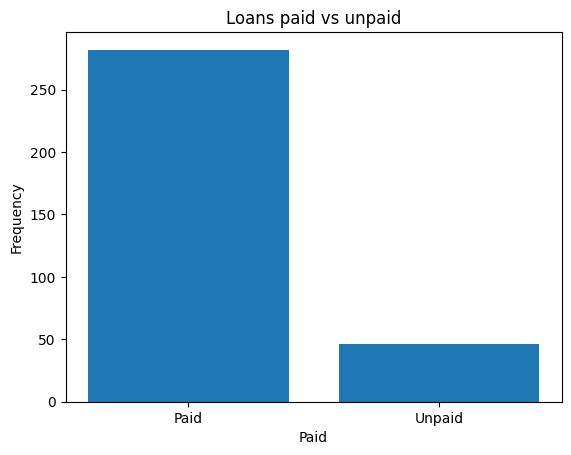

In [8]:
plt.figure()
plt.bar([0, 1], loan_data["paid"].value_counts(), tick_label=["Paid", "Unpaid"])
# plt.ylim(0, 300)
plt.title("Loans paid vs unpaid")
plt.xlabel("Paid")
plt.ylabel("Frequency")
plt.show()

### Investigate attributes with a large quantity of nulls

In [9]:
# TOOD: SPLIT THIS INTO DIFFERENT CELLS

def parse_k_symbol(k_symb):
    if isinstance(k_symb, float):
        return 'none'
    elif k_symb == " ":
        return 'none'
    else:
        return k_symb

print("=============================================\n")
print("[Operation]:")
print(transaction_data["operation"].value_counts())
operationNullsPercentage = round(len(transaction_data[transaction_data["operation"].isnull()]) / len(transaction_data["operation"]) * 100, 2)
print(f"Nulls (%): {operationNullsPercentage}%")
''' The operation attribute is categorical and doesn't reveal an inherited order. It can be encoded with 3 attributes
using binary encoding. We will fill the 'nulls' with "unknown"
'''

transaction_data['operation'].fillna("unknown", inplace=True)
# print(transaction_data["operation"].value_counts())

print("\n[k_symbol]:")
# print(transaction_data["k_symbol"].value_counts())
''' The k_symbol attribute is categorical and doesn't reveal an inherited order. It can be encoded with 3 attributes
using binary encoding. We will replace the " " with "none"
'''

transaction_data["k_symbol"] = transaction_data["k_symbol"].apply(parse_k_symbol)
print(transaction_data["k_symbol"].value_counts())
k_symbol_none_percentage = round(len(transaction_data[transaction_data["k_symbol"] == "none"]) / len(transaction_data["k_symbol"]) * 100, 2)
print(f"Nulls (%): {k_symbol_none_percentage}%")


print("\n[bank]:")
#print(transaction_data["bank"].value_counts())
print("Number of unknown banks:", len(transaction_data[transaction_data['bank'].isnull()]))

print("\n[account]:")
# print(transaction_data["account"].value_counts())
print("Number of unknown partners:", len(transaction_data[transaction_data['account'].isnull()]) + len(transaction_data[transaction_data['account'] == "0"]))

rows = transaction_data[transaction_data["bank"].isnull() & (~transaction_data["account"].isnull()) & (transaction_data["account"] != "0")]
print(f"Number of rows where bank is empty and the account isn't: {len(rows)}")
'''This proves that these 2 feature are highly correlated. Although these 2 attributes aren't likely to contribute anything to our prediction, we can create an
"unknown" bank and set all unknown account attributes to 0.'''

transaction_data["account"].fillna(0, inplace=True)
transaction_data["bank"].fillna("unknown", inplace=True)


[Operation]:
withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64
Nulls (%): 17.84%

[k_symbol]:
none                                     204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64
Nulls (%): 51.5%

[bank]:
Number of unknown banks: 299443

[account]:
Number of unknown partners: 299443
Number of rows where bank is empty and the account isn't: 0


In [10]:
# Auxiliary method to join 2 datasets
def join(df1, df2, key1, key2, suff, t="inner"):
    return df1.merge(df2, left_on=key1, right_on=key2, how=t, suffixes=suff)

## Dimensions of Data Quality

**Data quality dimension 6** - *Timeliness*
- The data in the dataset is outdated. Consequently, it does not achieve *timeliness*

**Data quality dimension 1** - *Completeness*
- Some mandatory fields were missing, hence the data cannot be considered *complete*.

**Data quality dimension 5** - *Integrity*
- Altough the objective of our work is to predict whether a loan will end successfuly, most of the accounts do not have associated loan requests - There are orphaned records. This means that the data lacks *Integrity*

**Data quality dimension 2** - *Consistency*
- A prime example of the lack of consistency is the overlapping info between the columns *type* and *operation* of the Transactions table. This info can be seen in the [*Join Transactions* section](#transactions_type_operation_comp)

**Data quality dimension 3** - *Conformity*
- Dates follow the format: "yy-mm-dd" in general. However, the client's birth date does not follow this format, since it adds 50 to the month part of the number. Thus, the data is not *conformant* 

### Join Data

It is needed to join all datasets into a single Dataframe

#### Join Account with Disposition

Let's first analyze the Disposition dataset:

Number of clients per disposition type:
OWNER        4500
DISPONENT     869
Name: type, dtype: int64


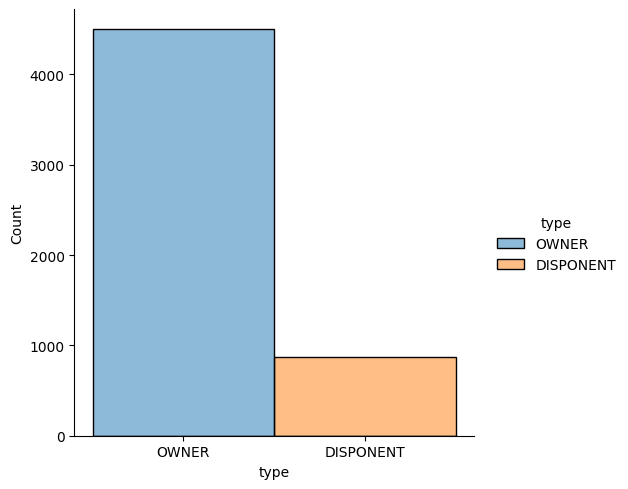

In [11]:
print("Number of clients per disposition type:")
print(disp_data["type"].value_counts())

sb.displot(disp_data, x="type", hue="type")
plt.show()

All Accounts have at least 1 Disposition. There are more Dispositions than Accounts, since some clients are **owners** while others are **disponent owners** 

We will create an attribute on the Account table that reflects whether the account is co-owned. Note that the DISPONENTs will be dropped from the joined table. The type attribute can be dropped as well since all dispositions are Owners.

In [12]:
df = join(account_data, disp_data, "account_id", "account_id", ["", "_disp"])
df.rename(columns={"date": "a_date"}, inplace=True)

# Count Groups
owner_count = df["account_id"].value_counts()
df["is_co-owned"] = df.apply(lambda row: 1 if owner_count[row["account_id"]] > 1 else 0, axis='columns')

# Cleanup
df.drop(df[df["type"] == "DISPONENT"].index, inplace=True)
df.drop(columns=["type"], inplace=True)

TODO: The column "disp_id" might also be useless since it's a 1-1 relation with the account now. But we
 will drop it after proving the correlation between the 2 attributes.'

### Join Clients

In [13]:
if not DATA_IS_LOADED:
    df = join(df, client_data, "client_id", "client_id", ["", "_client"], t="left")
    df.drop(['client_id'], axis='columns', inplace=True, errors='ignore')

#### Join Districts

Both the *Account* and the *Client* have a foreign key to the *District* table
We will for now add *District* info about both

In [14]:
if not DATA_IS_LOADED:
    # Add Client's District Data -> Change to MD
    df = join(df, district_data, "district_id_client", "code", ["", "_district"], t="inner")
    df.drop(['district_id_client'], axis='columns', inplace=True)

    # Add Accounts's District Data -> Change to MD
    df = join(df, district_data, "district_id", "code", ["_aDistrict", "_cDistrict"], t="inner")
    df.drop(['district_id'], axis='columns', inplace=True)
    
# df


Note that the district information regarding the *Account* contains an `a` prefix, while the *Client* info contains a `c` prefix.

Some of the Columns such as: *code_aDistrict* and *name_aDistrict* seem to be ambiguous. However, we will first confirm their correlation before removing them.

The next 3 tables have training and testing versions. Since we will do the data analysis of the training version, we'll ignore the other one for now

### Join Loan

In [15]:
if not DATA_IS_LOADED:
    # Merge to the right, since accounts that don't have loans are not relevant
    df = join(df, loan_data, "account_id", "account_id", ["", "_loan"], t="right")
    df.drop(['loan_id'], axis='columns', inplace=True)
    df.rename(columns={"date": "loan_date"}, inplace=True)
df

,account_id,frequency,a_date,disp_id,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid
0,1787,weekly issuance,1993-03-22,2166,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0
1,1801,monthly issuance,1993-02-13,2181,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1
2,9188,monthly issuance,1993-02-08,11006,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1
3,1843,monthly issuance,1993-01-30,2235,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.264670,35.857977,1993-08-03,105804,36,2939,1
4,11013,weekly issuance,1993-02-14,13231,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.055090,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,10813,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110.0,9672.0,9208,42.773370,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110.0,9672.0,9208,42.773370,40.721380,1996-12-12,155616,48,3242,1
324,3189,monthly issuance,1995-11-29,3855,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,1996-12-15,222180,60,3703,0
325,8972,monthly issuance,1996-05-21,10742,0,1957-05-04,0,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,1996-12-21,45024,48,938,1
326,10963,monthly issuance,1995-05-20,13172,0,1953-06-01,1,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,1996-12-25,115812,36,3217,1


### Join Card

Almost no *Client* in the dataset has a *Card*. This is rather problematic, since it creates a lot of missing values or lost of information.

The *Card* dataset contains only 2 useful columns:
- Card type -- can be ordered from worst to best
- Issuance date

The type of Card helps us rank clients. A *Client* with a gold card is better than a client with a junior card. On the other hand, the **issuance date** allows us to consider only cards that have been issued before the loan, as information after the loan is irrelevant for this prediction task. TODO: THIS LAST PART IS NOT DONE

The Card **type** is a categorical field:
- *junior* -- underage people (lowest tier), usually it isn't possible to withdraw money from them
- *classic*
- *gold* -- highest tier

**Since the field is ordered in tiers, in the cleaning process we should convert these values to a numerical scale where:**
- 0 -> no card
- 1 -> junior
- 2 -> classic
- 3 -> gold

In [16]:
if not DATA_IS_LOADED:
    card_disp = join(card_data, disp_data, "disp_id", "disp_id", ["_card", "_disp"])
    card_disp = card_disp.groupby([card_disp.account_id, card_disp.type_card]).size().unstack(fill_value=0)
card_disp

type_card,classic,gold,junior
account_id,,,
33,0,1,0
43,0,0,1
66,1,0,0
71,0,0,1
73,1,0,0
...,...,...,...
10227,1,0,0
10411,0,1,0
10520,0,1,0


In [17]:
if not DATA_IS_LOADED:
    df = join(df, card_data, "disp_id", "disp_id", ["", "_card"], t="left")
    df.fillna("none", inplace=True)
    df.drop(['card_id', 'disp_id'], axis='columns', inplace=True)
    df.rename(columns={"type": "card_type", "issued": "card_issued"}, inplace=True)

df


,account_id,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued
0,1787,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none
1,1801,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none
2,9188,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none
3,1843,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none
4,11013,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none
324,3189,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,1996-12-15,222180,60,3703,0,none,none
325,8972,monthly issuance,1996-05-21,0,1957-05-04,0,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,1996-12-21,45024,48,938,1,none,none
326,10963,monthly issuance,1995-05-20,0,1953-06-01,1,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,1996-12-25,115812,36,3217,1,none,none


There are very few clients who asked for a loan with cards. Every *Client* with a card has been granted a loan

In [18]:
df["card_type"].value_counts()

none       317
classic      8
gold         2
junior       1
Name: card_type, dtype: int64

In [19]:
df[df["card_type"] != "none"]["paid"].value_counts()

1    11
Name: paid, dtype: int64

### Join Transactions

We need to solve an issue with the *Transactions* table -- There are many transactions for some accounts. So, joining them would create multiple rows for each loan.

We need to find a way to extract the useful information from this table to merge it into the dataset.

Note that in this table the *account_id* columns refers to the **target account** of the operation, while the *account* refers to the source 

This table contains multiple categorical attributes. Before working with it, we should explore in more detail what they represent

In [20]:
transaction_data['type'].value_counts(dropna=False)

withdrawal            232093
credit                159468
withdrawal in cash      5124
Name: type, dtype: int64

In [21]:
transaction_data['operation'].value_counts(dropna=False)

withdrawal in cash              165270
unknown                          70761
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

<a id="transactions_type_operation_comp"></a>

The fields: *type* and *operation* seem to transmit identical information, where the *operation* goes into more detail about the type of transaction. Thus, after investigating the dataset we found the following mapping:

| type               | operation                                                              |
|--------------------|------------------------------------------------------------------------|
| credit             | unknown; collection from another bank, credit in cash                  |
| withdrawal         | credit card withdrawal; remittance to another bank; withdrawal in cash |
| withdrawal in cash | withdrawal in cash                                                     |

Consequently, this ambiguity will be taken into account towards the building of the final dataset.

In [22]:
transaction_data['k_symbol'].value_counts(dropna=False)

none                                     204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

In [23]:
def filter_missing_accounts():
    account_ids = df["account_id"].unique()
    return transaction_data.copy().loc[transaction_data["account_id"].isin(account_ids)]

if not DATA_IS_LOADED:
    active_transactions = filter_missing_accounts()

active_transactions.shape

(24494, 10)

Remove *Transactions* that happened after the respective loan decision 

In [24]:
RUN_COUNT_LATE_TRANSACTIONS = False # Bolean to skip this instruction if desired

def count_late_transactions():
    counter = 0
    for id, row in active_transactions.iterrows():
        transaction_date = row["date"]
        acc_id = row["account_id"]
        for _, loan_row in df[df["account_id"] == acc_id].iterrows():
            loan_date = loan_row["loan_date"]
            if transaction_date > loan_date:
                counter += 1
    
    return counter

if RUN_COUNT_LATE_TRANSACTIONS:
    if not DATA_IS_LOADED:
        late_transactions_count = count_late_transactions()

    print(f"Number of late transactions: {late_transactions_count}")

All *Transactions* happened before the loan decision, so none were dropped

To simplify the understanding of transactions:
- Withdrawals will have a negative *balance*
- Credit will have a positive *balance*

In [25]:
def convert_balance(transactions):
    def convert_bal_inner(row):
        amount = abs(row['amount'])
        return amount if row['type'] == 'credit' else -amount
    
    transactions['amount'] = transactions.apply(convert_bal_inner, axis='columns')
    return transactions

if not DATA_IS_LOADED:
    active_transactions = convert_balance(active_transactions)
active_transactions

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,none,unknown,0
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,none,IJ,80269753
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,none,unknown,0
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,none,unknown,0
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,none,unknown,0
...,...,...,...,...,...,...,...,...,...,...
24489,934562,3189,1996-12-10,withdrawal,withdrawal in cash,-6900.0,59578.8,none,unknown,0
24490,2729876,9030,1996-12-11,withdrawal,withdrawal in cash,-14600.0,60694.1,none,unknown,0
24491,2712272,8972,1996-12-13,withdrawal,remittance to another bank,-4719.0,56184.3,household,EF,61556398
24492,2712433,8972,1996-12-17,withdrawal,withdrawal in cash,-17800.0,38384.3,none,unknown,0


Regarding the *bank* and *account* columns, most entries are empty (83%). So these columns were considered not useful.

In [26]:
active_transactions[active_transactions['bank'] == "unknown"]["bank"].count() / active_transactions["bank"].count()

0.8296725728749897

In [27]:
if not DATA_IS_LOADED:
    active_transactions.drop(['bank', 'account'], axis='columns', inplace=True)

active_transactions

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,none
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,none
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,none
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,none
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,none
...,...,...,...,...,...,...,...,...
24489,934562,3189,1996-12-10,withdrawal,withdrawal in cash,-6900.0,59578.8,none
24490,2729876,9030,1996-12-11,withdrawal,withdrawal in cash,-14600.0,60694.1,none
24491,2712272,8972,1996-12-13,withdrawal,remittance to another bank,-4719.0,56184.3,household
24492,2712433,8972,1996-12-17,withdrawal,withdrawal in cash,-17800.0,38384.3,none


### Sanctions for Negative Balance
Knowing the number of times each *User* was sanctioned for **negative balance** might be useful to know which loans to reject

In [28]:
def count_sanctions(df, active_transactions):
    grouped = active_transactions.groupby('account_id')

    sanction_df = pd.DataFrame(columns=['account_id', 'sanctions'])
    for acc_id, group in grouped:
        sanction_count = group[group['k_symbol'] == "sanction interest if negative balance"]["k_symbol"].count()
        sanction_df = pd.concat([sanction_df, pd.DataFrame({'account_id': acc_id, 'sanctions': sanction_count}, index=[0])], ignore_index=True)

    df["sanctions"] = sanction_df["sanctions"]
    df["sanctions"].fillna(0.0, inplace=True)
    return df

if not DATA_IS_LOADED:
    df = count_sanctions(df, active_transactions)

# df["sanctions"].value_counts()
df
    

,account_id,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions
0,1787,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none,0
1,1801,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none,0
2,9188,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none,0
3,1843,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none,0
4,11013,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none,0
324,3189,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,1996-12-15,222180,60,3703,0,none,none,0
325,8972,monthly issuance,1996-05-21,0,1957-05-04,0,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,1996-12-21,45024,48,938,1,none,none,0
326,10963,monthly issuance,1995-05-20,0,1953-06-01,1,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913,19.950815,20.366013,1996-12-25,115812,36,3217,1,none,none,0


### Mean Household Payments

Knowing how much a client pays for its house may be a useful metric to know its financial situation

In [29]:
def household_mean(df, active_transactions):
    grouped = active_transactions.groupby("account_id")
    household_df = pd.DataFrame(columns=["account_id", "household_mean"])

    for acc_id, group in grouped:
        house_mean = abs(group[group["k_symbol"] == "household"]["amount"].mean())
        household_df = pd.concat([household_df, pd.DataFrame({'account_id': acc_id, 'household_mean': house_mean}, index=[0])], ignore_index=True)

    df["household_mean"] = household_df["household_mean"]
    df["household_mean"].fillna(0.0, inplace=True)
    return df

if not DATA_IS_LOADED:
    df = household_mean(df, active_transactions)

df["household_mean"].head()

0     7266.0
1    15925.0
2     6393.0
3        0.0
4     6256.0
Name: household_mean, dtype: float64

### Mean Interest Payments
Knowing how much a client earns in **account interest** might be useful

In [30]:
def interest_mean(df, active_transactions):
    grouped = active_transactions.groupby("account_id")
    interest_df = pd.DataFrame(columns=["account_id", "interest_mean"])

    for acc_id, group in grouped:
        interest_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
        interest_df = pd.concat([interest_df, pd.DataFrame({'account_id': acc_id, 'interest_mean': interest_mean}, index=[0])], ignore_index=True)

    df["interest_mean"] = interest_df["interest_mean"]
    df["interest_mean"].fillna(0.0, inplace=True)
    return df

if not DATA_IS_LOADED:
    df = interest_mean(df, active_transactions)

df["interest_mean"].head()

0    128.930000
1    118.091667
2    193.711111
3    252.633333
4    122.200000
Name: interest_mean, dtype: float64

### Mean Balance in Time References

The mean balance in the account **1 month**, **1 semester**, and **1 year** before the loan request

In [31]:
def balance_time_references(df, active_transactions):
    def to_datetime(df, col_name="date"):
        df[col_name + "_dt"] = pd.to_datetime(df[col_name], format="%Y-%m-%d")
    
    to_datetime(df, "loan_date")
    to_datetime(active_transactions)

    # Join current dataset with transactions so that we can group by account_id
    temp_df = join(df, active_transactions, "account_id", "account_id", suff=["", "_trans"])[["account_id", "trans_id", "date_dt", "balance", "loan_date_dt"]]

    # Calculate month's offset between each transaction and loan date
    temp_df['month_diff'] = (temp_df['loan_date_dt'] - temp_df['date_dt']) / np.timedelta64(1, 'M')

    # 
    def avg_balance(dataframe, balance_name):
        return dataframe.groupby('account_id').mean()['balance'].reset_index().rename(columns={'balance': balance_name})

    # Create 3 Tables for the average balance in an account in the previous month, semester and year (account_id, balance)
    prev_year = avg_balance(temp_df.loc[temp_df['month_diff'] <= 12], 'prev_year_balance') 
    prev_semester = avg_balance(temp_df.loc[temp_df['month_diff'] <= 6], 'prev_6m_balance')
    prev_month = avg_balance(temp_df.loc[temp_df['month_diff'] <= 1], 'prev_1m_balance')

    mergedDf = df.merge(prev_year, on='account_id', how='inner')
    mergedDf = mergedDf.merge(prev_semester, on='account_id', how='inner')
    mergedDf = mergedDf.merge(prev_month, on='account_id', how='inner')

    mergedDf.drop(['loan_date_dt'], axis='columns', inplace=True)

    return mergedDf

if not DATA_IS_LOADED:
    df = balance_time_references(df, active_transactions)

df
    

/tmp/ipykernel_11600/383325583.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return dataframe.groupby('account_id').mean()['balance'].reset_index().rename(columns={'balance': balance_name})
/tmp/ipykernel_11600/383325583.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return dataframe.groupby('account_id').mean()['balance'].reset_index().rename(columns={'balance': balance_name})
/tmp/ipykernel_11600/383325583.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or selec

,account_id,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance
0,1787,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000
1,1801,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889
2,9188,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667
3,1843,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none,0,0.0,252.633333,41297.480000,42976.541667,42535.133333
4,11013,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429
324,3189,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,1996-12-15,222180,60,3703,0,none,none,0,506.0,90.257143,57349.860714,63100.352632,67639.628571
325,8972,monthly issuance,1996-05-21,0,1957-05-04,0,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108,34.612649,35.418572,1996-12-21,45024,48,938,1,none,none,0,10886.0

### Min, Max and Mean Balances

it's also relevant to store some statistics regarding the balance of the clients along time

In [32]:
def client_balance(df, active_transactions):
    grouped = active_transactions.groupby("account_id")
    balance_df = pd.DataFrame(columns=["account_id", "balance_min", "balance_max", "balance_mean"])

    for acc_id, group in grouped:
        client_balance = group["balance"]
        balance_df = pd.concat([balance_df, pd.DataFrame({'account_id': acc_id, 'balance_min': client_balance.min(), 'balance_max': client_balance.max(), 
            'balance_mean': client_balance.mean()}, index=[0])], ignore_index=True)

    balance_df.fillna(0.0, inplace=True)
    df = join(df, balance_df, "account_id", "account_id", suff=['', ''])
    return df

if not DATA_IS_LOADED:
    df = client_balance(df, active_transactions)

df

,account_id,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean
0,1787,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000
1,1801,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459
2,9188,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167
3,1843,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000
4,11013,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884
324,3189,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,1996-12-15,222180,60,3703,0,none,none,0,506.0,90.257143,57349.860714,63100.352632,67639.628571,800.0,130659.1,55230.444068
325,8972,monthly issuance,1996-05-21,0,1957-05-04,0,70,K

### Average balance Influx
Knowing the **balance variation** of a client might prove to be an useful metric, as it portrays the tendencies of the account. Consequently, we will create 3 columns to store the average influx (money IN - money OUT) in the last 3, 6 and 12 months.


In [33]:
def client_bal_influx(df, active_transactions):
    def to_datetime(df, col_name="date"):
        df[col_name + "_dt"] = pd.to_datetime(df[col_name], format="%Y-%m-%d")

    to_datetime(df, "loan_date")
    to_datetime(active_transactions)

    # Join current dataset with transactions so that we can group by account_id
    temp_df = join(df, active_transactions, "account_id", "account_id", suff=["", "_trans"])[["account_id", "date_dt", "loan_date_dt", "amount_trans"]]
    temp_df.rename(columns={'amount_trans': 'influx'}, inplace=True)

    # Calculate month's offset between each transaction and loan date
    temp_df['month_diff'] = (temp_df['loan_date_dt'] - temp_df['date_dt']) / np.timedelta64(1, 'M')

    # Calculate sum of influxes from the given Rows
    def balance_influx(dataframe, balance_name):
        return dataframe.groupby('account_id').sum(numeric_only=True)['influx'].reset_index().rename(columns={'influx': balance_name})

    # Create 3 Tables for the average influx in the last 3, 6 and 12 months
    prev_year = balance_influx(temp_df.loc[temp_df['month_diff'] <= 12], 'mean_year_influx')
    prev_year['mean_year_influx'] = prev_year['mean_year_influx'] / 12  # Average Influx per Month

    prev_6month = balance_influx(temp_df.loc[temp_df['month_diff'] <= 6], 'mean_6m_influx')
    prev_6month['mean_6m_influx'] = prev_6month['mean_6m_influx'] / 6  # Average Influx per Month

    prev_3month = balance_influx(temp_df.loc[temp_df['month_diff'] <= 3], 'mean_3m_influx')
    prev_3month['mean_3m_influx'] = prev_3month['mean_3m_influx'] / 3  # Average Influx per Month

    mergedDf = df.merge(prev_year, on='account_id', how='inner')
    mergedDf = mergedDf.merge(prev_6month, on='account_id', how='inner')
    mergedDf = mergedDf.merge(prev_3month, on='account_id', how='inner')

    mergedDf.drop(['loan_date_dt'], axis='columns', inplace=True)

    return mergedDf

if not DATA_IS_LOADED:
    df = client_bal_influx(df, active_transactions)

df

,account_id,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx
0,1787,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333
1,1801,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667
2,9188,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333
3,1843,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000
4,11013,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000
324,3189,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121

Now that we have extracted the desired information from all the tables, we can drop the account_id

In [34]:
if not DATA_IS_LOADED:
     df.drop(['account_id'], axis='columns', inplace=True)

### Check Duplicate rows

In [35]:
df.drop(df.drop_duplicates().index)

,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx


There are no duplicate rows

## Save the Joined Data

In [36]:
from pathlib import Path

filepath = Path("../../assets/joined")
filepath.mkdir(parents=True, exist_ok=True)

df.to_csv("../../assets/joined/data.csv", index=False)

### Final Dataset:

In [37]:
df

,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx
0,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483357,29.574315,1993-07-05,96396,12,8033,0,none,none,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333
1,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.321847,23.227959,1993-07-11,165960,36,4610,1,none,none,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667
2,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695073,27.234108,1993-07-28,127080,60,2118,1,none,none,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333
3,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467,35.857977,1993-08-03,105804,36,2939,1,none,none,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000
4,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05509,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.104018,82.249681,1993-09-06,274740,60,4579,1,none,none,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.77337,40.721380,1996-12-12,155616,48,3242,1,none,none,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000
324,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,88

===================

In [38]:
# Variable used to avoid re-running certain cells
DATA_IS_LOADED = True